In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tqdm.notebook import tqdm

In [2]:
# Load the dataset
df = pd.read_csv('C:/Users/Lenovo/Desktop/staj_code2/creditcard.csv')

# Sample the data
df_sample = df.sample(frac=0.3, random_state=42)

In [3]:
# Split features and target
X = df_sample.drop('Class', axis=1)
y = df_sample['Class']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to handle class imbalance
smote = SMOTE(sampling_strategy=0.3, random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [4]:
# Define parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Perform RandomizedSearchCV with progress bar
random_search = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42),
                                   param_distributions=param_grid,
                                   n_iter=10, 
                                   cv=5,  
                                   n_jobs=-1, verbose=2, scoring='roc_auc')

In [5]:
# Fit the model
with tqdm(total=100, desc="Hyperparameter Tuning") as pbar:
    random_search.fit(X_train_res, y_train_res)
    pbar.update(100)

# Best model from RandomizedSearchCV
best_rf_model = random_search.best_estimator_

# Fit the best Random Forest model
best_rf_model.fit(X_train_res, y_train_res)

# Feature Importance
importances = best_rf_model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

Hyperparameter Tuning:   0%|          | 0/100 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


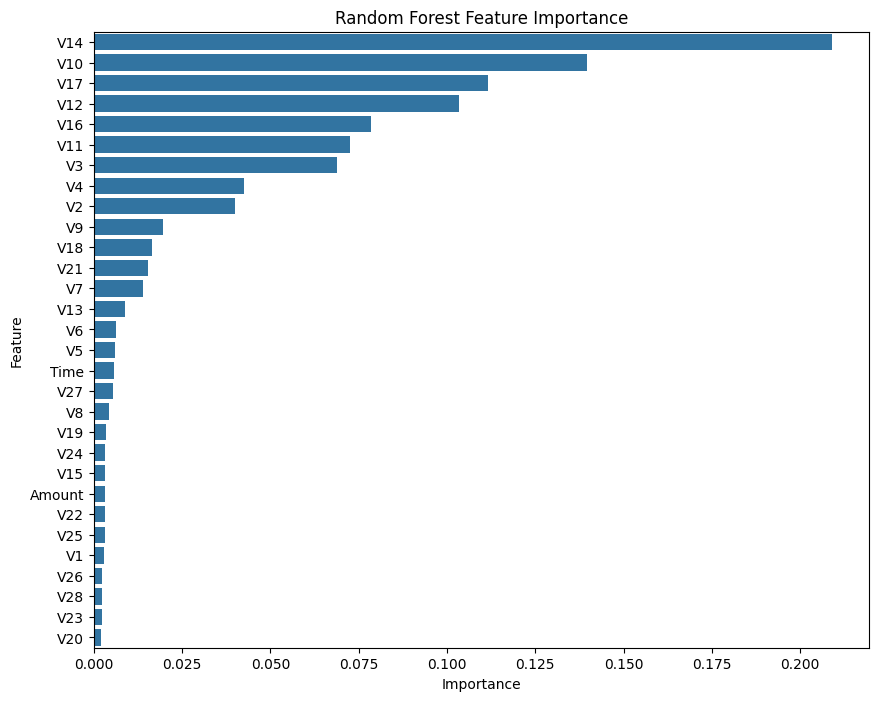

In [6]:
# Plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Random Forest Feature Importance')
plt.show()

In [10]:
print("Top 10 Important Features:")
print(importance_df.head(10))
# Save the model
model_filename = 'C:/Users/Lenovo/Documents/random_forest_fraud_model1.pkl'
joblib.dump(best_rf_model, model_filename)
print(f"Model saved as {model_filename}")

Top 10 Important Features:
   Feature  Importance
14     V14    0.209001
10     V10    0.139598
17     V17    0.111598
12     V12    0.103485
16     V16    0.078551
11     V11    0.072632
3       V3    0.068841
4       V4    0.042399
2       V2    0.039918
9       V9    0.019728
Model saved as C:/Users/Lenovo/Documents/random_forest_fraud_model1.pkl


In [11]:
# Cross-validation for ROC AUC
cv_scores = cross_val_score(best_rf_model, X_train_res, y_train_res, cv=5, scoring='roc_auc')

print(f"Cross-Validation ROC AUC Scores: {cv_scores}")
print(f"Mean ROC AUC Score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")


Cross-Validation ROC AUC Scores: [0.99999788 0.99999902 0.99999996 0.99999907 0.99999998]
Mean ROC AUC Score: 1.0000 (+/- 0.0000)


In [12]:
# Ensemble model with Logistic Regression
log_reg = LogisticRegression(max_iter=2000, random_state=42)

ensemble_model = VotingClassifier(estimators=[
    ('rf', best_rf_model),
    ('lr', log_reg)
], voting='soft')

# Fit ensemble model
ensemble_model.fit(X_train_res, y_train_res)

# Predict and evaluate ensemble model
y_pred_ensemble = ensemble_model.predict(X_test)
y_pred_prob_ensemble = ensemble_model.predict_proba(X_test)[:, 1]

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [13]:
# ROC AUC score for ensemble model
ensemble_roc_auc = auc(*roc_curve(y_test, y_pred_prob_ensemble)[:2])
print(f"Ensemble Model ROC AUC Score: {ensemble_roc_auc:.4f}")

print("\nEnsemble Model - Classification Report")
print(classification_report(y_test, y_pred_ensemble))

Ensemble Model ROC AUC Score: 0.9683

Ensemble Model - Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17060
           1       0.60      0.97      0.74        29

    accuracy                           1.00     17089
   macro avg       0.80      0.98      0.87     17089
weighted avg       1.00      1.00      1.00     17089



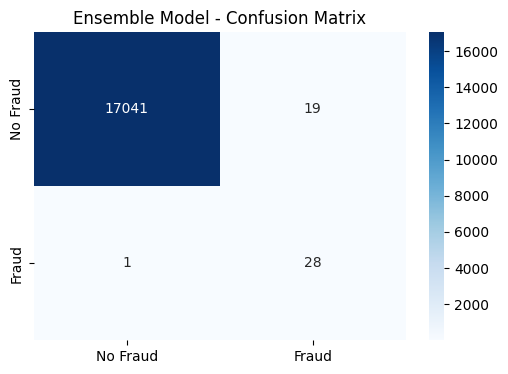

In [14]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_ensemble)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Fraud", "Fraud"], yticklabels=["No Fraud", "Fraud"])
plt.title('Ensemble Model - Confusion Matrix')
plt.show()

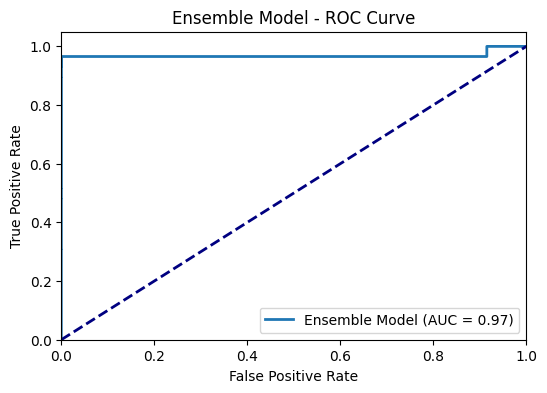

In [15]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_ensemble)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, lw=2, label=f'Ensemble Model (AUC = {ensemble_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Ensemble Model - ROC Curve')
plt.legend(loc="lower right")
plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11864\3264360092.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Class', data=df, palette=colors)


([<matplotlib.axis.XTick at 0x271ee370170>,
 [Text(0, 0, 'Non-Fraudulent (0)'), Text(1, 0, 'Fraudulent (1)')])

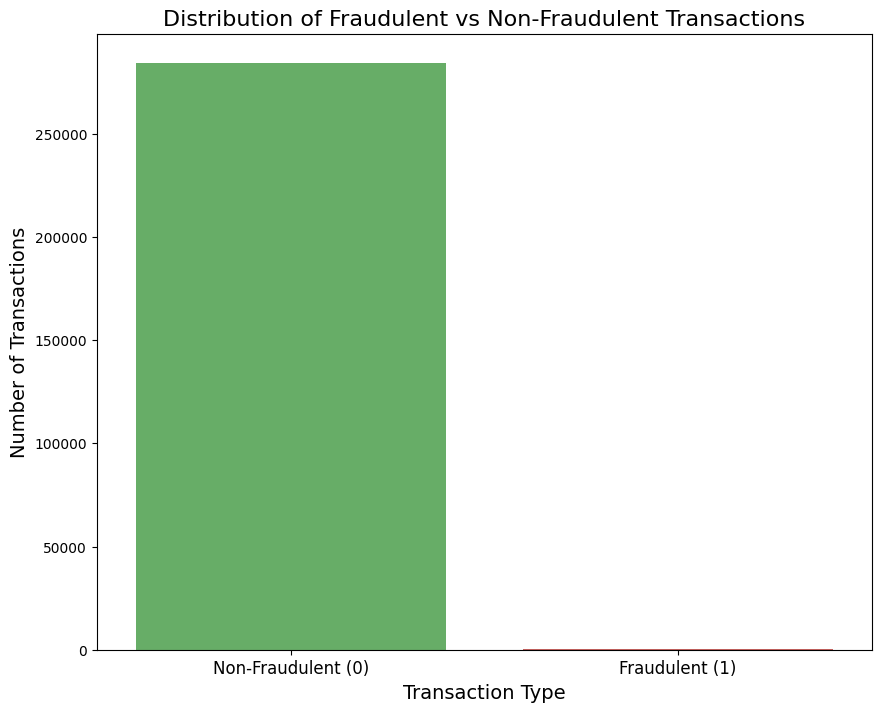

In [16]:
# Distribution of Fraudulent vs Non-Fraudulent Transactions
plt.figure(figsize=(10, 8))
colors = ['#5cb85c', '#d9534f']
ax = sns.countplot(x='Class', data=df, palette=colors)
plt.title('Distribution of Fraudulent vs Non-Fraudulent Transactions', fontsize=16)
plt.xlabel('Transaction Type', fontsize=14)
plt.ylabel('Number of Transactions', fontsize=14)
plt.xticks([0, 1], ['Non-Fraudulent (0)', 'Fraudulent (1)'], fontsize=12)

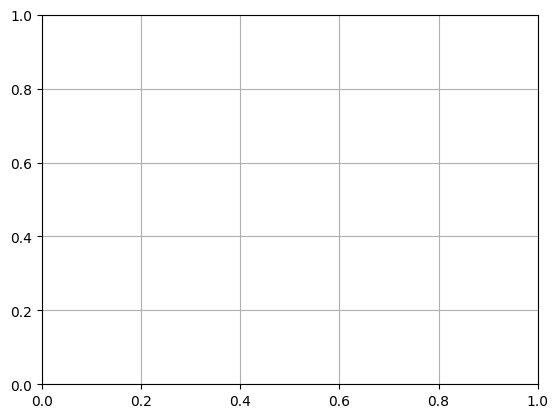

Fraudulent Transactions: 0.17%
Non-Fraudulent Transactions: 99.83%


In [17]:
# Annotate percentages
total = len(df)
for p in ax.patches:
    height = p.get_height()
    percentage = 100 * height / total
    ax.annotate(f'{percentage:.2f}%', 
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', 
                xytext=(0, 10), textcoords='offset points',
                fontsize=12, color='black')

plt.grid(True)
plt.show()
# Fraud ratio
fraud_ratio = df['Class'].value_counts(normalize=True) * 100
print(f"Fraudulent Transactions: {fraud_ratio[1]:.2f}%")
print(f"Non-Fraudulent Transactions: {fraud_ratio[0]:.2f}%")

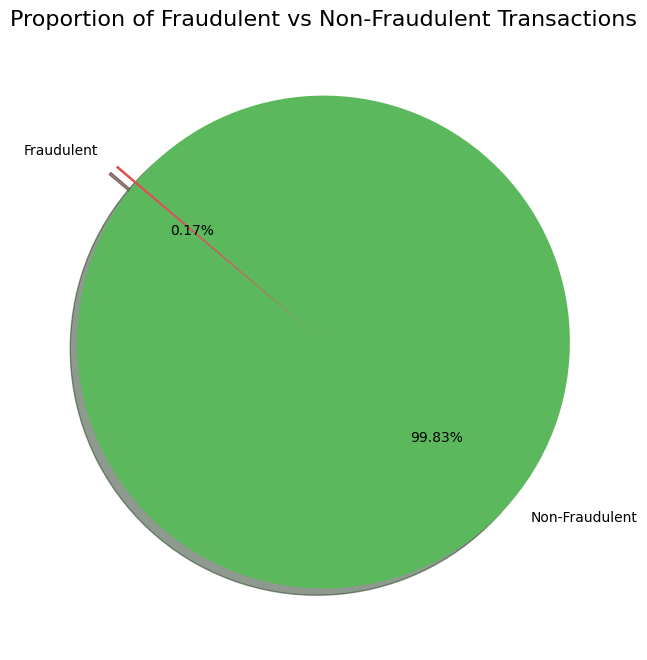

In [18]:


# Proportion of Fraudulent vs Non-Fraudulent Transactions
plt.figure(figsize=(8, 8))
class_counts = df['Class'].value_counts()
labels = ['Non-Fraudulent', 'Fraudulent']
colors = ['#5cb85c', '#d9534f']
plt.pie(class_counts, labels=labels, colors=colors, autopct='%1.2f%%', startangle=140, explode=[0, 0.1], shadow=True)
plt.title('Proportion of Fraudulent vs Non-Fraudulent Transactions', fontsize=16)
plt.show()

In [24]:
def generate_random_transaction():
    random_transaction = {
        'Time': np.random.uniform(0, 172800),  
        'V1': np.random.uniform(-5, 5),
        'V2': np.random.uniform(-5, 5),
        'V3': np.random.uniform(-5, 5),
        'V4': np.random.uniform(-5, 5),
        'V5': np.random.uniform(-5, 5),
        'V6': np.random.uniform(-5, 5),
        'V7': np.random.uniform(-5, 5),
        'V8': np.random.uniform(-5, 5),
        'V9': np.random.uniform(-5, 5),
        'V10': np.random.uniform(-5, 5),
        'V11': np.random.uniform(-5, 5),
        'V12': np.random.uniform(-5, 5),
        'V13': np.random.uniform(-5, 5),
        'V14': np.random.uniform(-5, 5),
        'V15': np.random.uniform(-5, 5),
        'V16': np.random.uniform(-5, 5),
        'V17': np.random.uniform(-5, 5),
        'V18': np.random.uniform(-5, 5),
        'V19': np.random.uniform(-5, 5),
        'V20': np.random.uniform(-5, 5),
        'V21': np.random.uniform(-5, 5),
        'V22': np.random.uniform(-5, 5),
        'V23': np.random.uniform(-5, 5),
        'V24': np.random.uniform(-5, 5),
        'V25': np.random.uniform(-5, 5),
        'V26': np.random.uniform(-5, 5),
        'V27': np.random.uniform(-5, 5),
        'V28': np.random.uniform(-5, 5),
        'Amount': np.random.uniform(0, 500)  
    }
    
    return random_transaction

new_random_transaction = generate_random_transaction()

new_data = pd.DataFrame([new_random_transaction])
prediction, fraud_prob = ensemble_model.predict(new_data), ensemble_model.predict_proba(new_data)[:, 1]

if prediction == 1:
    print(f"The transaction is predicted to be FRAUDULENT with a probability of {fraud_prob[0]:.2f}.")
else:
    print(f"The transaction is predicted to be NON-FRAUDULENT with a probability of {fraud_prob[0]:.2f}.")
    
new_data = pd.DataFrame([new_random_transaction])
prediction, fraud_prob = ensemble_model.predict(new_data), ensemble_model.predict_proba(new_data)[:, 1]

threshold = 0.5

if fraud_prob[0] > threshold:
    print(f"The transaction is considered DANGEROUS with a fraud probability of {fraud_prob[0]:.2f}.")
else:
    print(f"The transaction is considered SAFE with a fraud probability of {fraud_prob[0]:.2f}.")

The transaction is predicted to be NON-FRAUDULENT with a probability of 0.06.
The transaction is considered SAFE with a fraud probability of 0.06.
